## Xem hiệu quả giữa các loại regression dựa trên bài toán dự đoán giá cổ phiếu bằng các mô hình phổ biến như: Linear Regression, Polynomial Regression, Support Vector Regression, Decision Tree Regression, Random Forest Regression


### Chuẩn bị data cho regression

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mysql.connector
from vnstock import *

def get_news_date(date_start, date_end):
    # Establish a connection to the MySQL database
    connection = mysql.connector.connect(
        host='127.0.0.1',
        port=13306,
        user='root',
        password='root',
        database='pyml'
    )

    # Read the table data using pandas
    query = f"""
        SELECT title, content, date FROM crawl_data
        where date >= '{date_start}' and date <= '{date_end}'
    """
    df = pd.read_sql(query, connection)
    return df

# Lấy data tin tức từ ngày {start} đến ngày {end} và merge với giá stock thành dataframe.
def get_data(stock, date_start, date_end, export_url=None):
    df = get_news_date(date_start, date_end)
    df['date_only'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')


    df_his = stock_historical_data(stock, date_start, date_end, "1D", 'stock')
    df_his['date'] = pd.to_datetime(df_his['time']).dt.strftime('%Y-%m-%d')


    dfMerge = pd.merge(df, df_his, left_on=['date_only'], right_on=['date'], how='inner')
    dfSumarize = dfMerge[['title', 'close', 'date_y']]

    # Sorting the DataFrame by the 'date_column' in ascending order

    df_sorted = dfSumarize.sort_values(by='date_y', ascending=True)
    if export_url:
        df_sorted.to_csv(export_url, index=True)

    return df_sorted

In [7]:
df_data = get_data('VPB', '2022-01-01', '2023-08-30')
df_data.head()

/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_2053/31636148.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,title,close,date_y
3192,VNDIRECT: Hầu hết giá cổ phiếu của dệt may hiệ...,24030,2022-01-04
3191,Cách tốt nhất để các nhà đầu tư bảo vệ mình kh...,24030,2022-01-04
3190,Đảng uỷ cơ quan Uỷ ban Chứng khoán Nhà nước: S...,24030,2022-01-04
3189,Truyền hình K+ tặng đầu thu miễn phí đón ‘Tết ...,24030,2022-01-04
3188,Licogi 14 (L14) “bơm” thêm 214 tỷ đồng đầu tư ...,23670,2022-01-05


In [13]:
news = get_news_date('2023-08-29', '2023-08-31')
x_test_raw = news['title']
print(x_test_raw[:2], len(x_test_raw))


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_45402/61538518.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


0    TP.HCM muốn lấy cát nhiễm mặn làm khu đô thị l...
1       29/08: Đọc gì trước giờ giao dịch chứng khoán?
Name: title, dtype: object 50


In [48]:
import regress
import regress_adapter
from importlib import reload
import helper

reload(helper)
reload(regress)
reload(regress_adapter)


nlp = helper.NLP(text)
print(nlp.get_words_feature())
print(nlp.get_string_sanitize())

Không tìm thấy file cmword.csv
['bộ', 'công_thương', 'chịu', 'trách_nhiệm', 'trước', 'chính_phủ', 'quản_lý', 'nhà_nước', 'về', 'điện_lực', 'trong', 'đó', 'có', 'giá', 'điện', 'nên', 'bộ', 'tài_chính', 'đề_nghị', 'không', 'quy_định', 'trách_nhiệm', 'phối_hợp', 'rà_soát', 'của', 'bộ', 'này', 'khi', 'điều_chỉnh', 'giá']
bộ công_thương chịu trách_nhiệm trước chính_phủ quản_lý nhà_nước về điện_lực trong đó có giá điện nên bộ tài_chính đề_nghị không quy_định trách_nhiệm phối_hợp rà_soát của bộ này khi điều_chỉnh giá


In [66]:
import regress
import regress_adapter
import matplotlib.pyplot as plt
from importlib import reload

reload(helper)
reload(regress)
reload(regress_adapter)

bot = regress_adapter.BotRegress('VPB', '2022-01-01', '2023-07-22', 'tfidf', 'randomforest')
bot.fit(cache=False)

/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


init tfidf None


/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


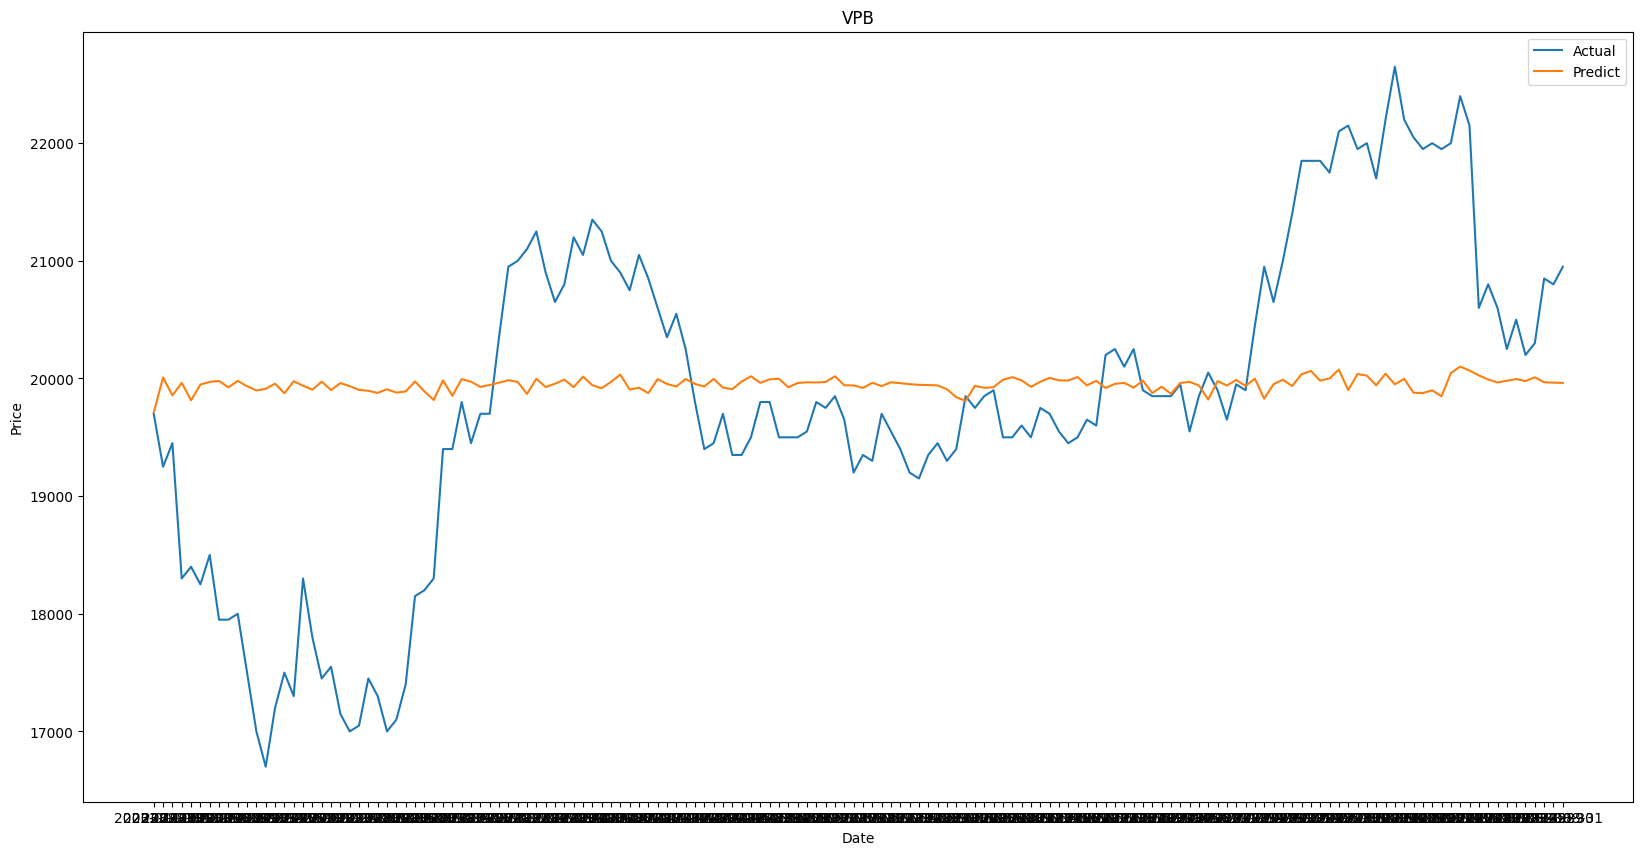

In [67]:
bot.predict_chart('VPB', '2023-01-23', '2023-09-05')

In [31]:
reload(regress)
reload(regress_adapter)

botPhobert = regress_adapter.BotRegress('VPB', '2022-01-01', '2023-07-22', transform_type='sequence', algorithm='linear')
botPhobert.fit()

/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2 reload(regress_adapter)                                                                      │
│   3                                                                                              │
│   4 botPhobert = regress_adapter.BotRegress('VPB', '2022-01-01', '2023-07-22', transform_typ     │
│ ❱ 5 botPhobert.fit()                                                                             │
│   6                                                                                              │
│                                                                                                  │
│ /Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:73 in fit               │
│                                                                                                  │
│    70 │                                                                                          │
│    71 │   def fit(self, cache=False):                                                            │
│    72 │   │   self.modelClass = regress.RegressionTextToPrice(transform_type=self.transform_ty   │
│ ❱  73 │   │   self.modelClass.fit(self.x_train_raw, self.y_train_raw, cache=cache)               │
│    74 │                                                                                          │
│    75 │   """                                                                                    │
│    76 │   │   Predict stock price by date                                                        │
│                                                                                                  │
│ /Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress.py:166 in fit                      │
│                                                                                                  │
│   163 │   │   │   return                                                                         │
│   164 │   │   self.x_train_raw = np.array(x_train) if isNumpy(x_train) else x_train              │
│   165 │   │   self.y_train_raw = np.array(y_train) if isNumpy(y_train) else y_train              │
│ ❱ 166 │   │   self.x_train = self.transformer.fit_transform(self.x_train_raw)                    │
│   167 │   │   self.y_train = self.y_train_raw                                                    │
│   168 │   │                                                                                      │
│   169 │   │   if self.algorithm == 'svr':                                                        │
│                                                                                                  │
│ /Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress.py:120 in fit_transform            │
│                                                                                                  │
│   117 │                                                                                          │
│   118 │   def fit_transform(self, data):                                                         │
│   119 │   │   self.tokenizer = Tokenizer(num_words=10000)                                        │
│ ❱ 120 │   │   self.tokenizer.fit_on_texts(data)                                                  │
│   121 │   │   data_transformed = self.tokenizer.texts_to_sequences(data)                         │
│   122 │   │   data_transformed = pad_sequences(data_transformed, maxlen = self.max_len, paddin   │
│   123 │   │   return data_transformed                                                            │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-pac

/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_2053/31636148.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


load cache


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_2053/31636148.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddedTitle = self.model(torch.tensor(encodedTextInputIds))


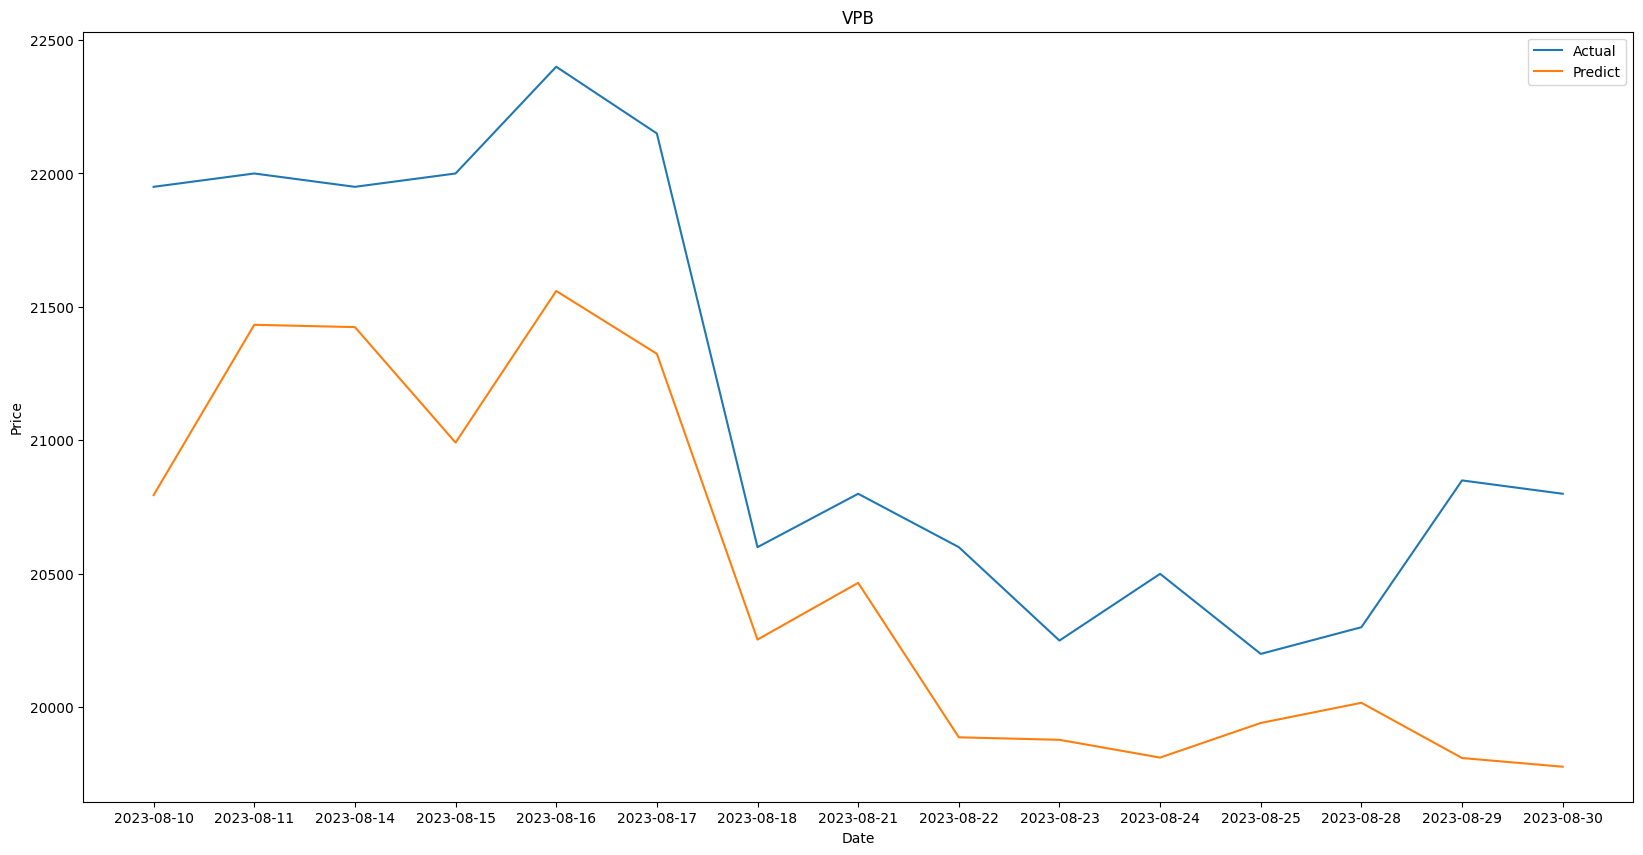

In [29]:
botPhobert.predict_chart('VPB', '2023-08-10', '2023-08-31')

Model phobert 